# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Applying KNN brute force

### Applying KNN brute force on BOW

In [2]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning :Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


## Preprocessing

## Prerpocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:24<00:00, 1908.51it/s]


In [14]:
type(preprocessed_reviews)

list

In [15]:
len(preprocessed_reviews)

46071

In [16]:
preprocessed_reviews[5]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

In [17]:
final.shape

(46071, 10)

In [18]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [19]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [20]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descending order beased on Time Column

In [21]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [24]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
8731,9564,B001EQ5IPQ,AA2104NO2VE8H,Lakshminarayan Iyer,0,0,0,1351209600,Extremely dissapointed,"Hi,<br />I am very disappointed with the past ...",hi disappointed past shipment received one coc...
7451,8135,B0019GVYR2,ACSO5EDO1UMZ5,SeekingBodhi,0,0,0,1351209600,NEWSFLASH,I just called Bob's Red Mill customer service ...,called bob red mill customer service g search ...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
24496,26772,B004ZY4TK4,A4IL0CLL27Q33,D. Brennan,0,0,0,1351209600,Buyer beware,Nespresso makes GREAT coffee and GREAT machine...,nespresso makes great coffee great machines sw...
42269,45991,B007VQQT1K,A34P4V70RNC2YV,S. Guss,0,0,1,1351209600,Great Irish Tea,We recently returned from a wonderful three we...,recently returned wonderful three week excursi...
43268,47077,B001C4PKIK,A3IMXYITIO8WHN,Thomas R. Jackson,0,0,1,1351209600,Great food!,I wanted a food for a a dog with skin problems...,wanted food dog skin problems skin greatly imp...
14526,15842,B007TJGZ5E,A3UOYYQS5Z47MS,"David A. Levin ""DaveL""",0,0,1,1351209600,Morning Coffee,Great coffee at a good price. I'm a subscripti...,great coffee good price subscription buyer buy...
15069,16426,B007TJGZ54,A29BJSTYH9W3JI,Harry,0,0,1,1351209600,super coffee,Great coffee and so easy to brew. This coffee...,great coffee easy brew coffee great aroma good...
25112,27424,B003WEFSAI,A37O0JPLJ8BOXP,Texaschick59,0,0,1,1351209600,Drink mix,We love this drink mix it taste delicious and ...,love drink mix taste delicious impossible yo f...


In [25]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [26]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
8731,hi disappointed past shipment received one coc...,0
7451,called bob red mill customer service g search ...,0
39050,used years gives long lasting energy boost no ...,1
24496,nespresso makes great coffee great machines sw...,0


In [27]:
final_df.shape

(46071, 2)

In [28]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [29]:
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [31]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=3,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) # this is random splitting

In [32]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(29484,) (29484,)
(7372,) (7372,)
(9215,) (9215,)


In [33]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(29484, 31616) (29484,)
(7372, 31616) (7372,)
(9215, 31616) (9215,)


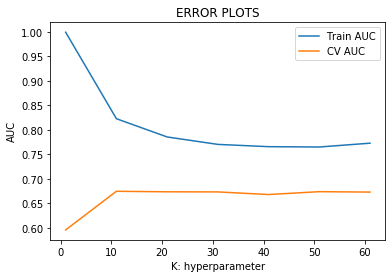

In [50]:
# Hyper parameter tuning to find best k
# Simple Cross validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = list(range(1,71,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    y_test_pred=neigh.predict_proba(X_test_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above graph,we can see that the curves are close at k value anything between 50 and 55.Therefore,I have taken
k value anything between 50 and 55.

## Scaling the vectorized data before applying KNN 

In [157]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

In [52]:
type(X_train_bow_std)

scipy.sparse.csr.csr_matrix

## Building KNN model with best k value:55 on "brute" and BOW

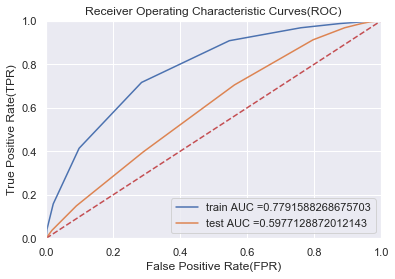

In [158]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

KNN = KNeighborsClassifier(n_neighbors=55,algorithm='brute',n_jobs=-1)
KNN.fit(X_train_bow_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, KNN.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, KNN.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix

In [30]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [160]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5126406711057436 for threshold 0.909

Train confusion matrix:

[[ 5121   148]
 [12206 12009]]

Test confusion matrix:

[[1109   58]
 [4026 4022]]


## Plotting Confusion matrix using Seaborn

In [161]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

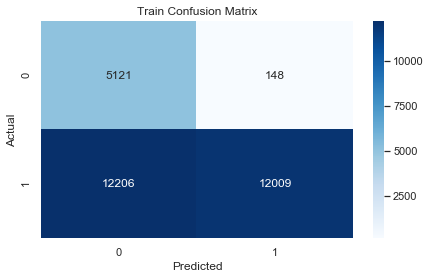

In [162]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

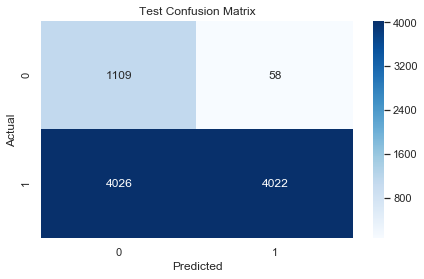

In [163]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

###  Applying KNN brute force on TFIDF

In [164]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(29484, 31616) (29484,)
(7372, 31616) (7372,)
(9215, 31616) (9215,)


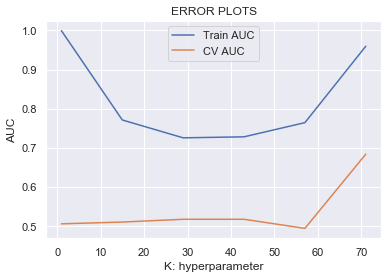

In [165]:
# Hyper parameter tuning to find best k
# Simple Cross validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = list(range(1,72,14))
for i in K:
    neigh1 = KNeighborsClassifier(n_neighbors=i)
    neigh1.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh1.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh1.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred=neigh1.predict_proba(X_test_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above grap,we can see that the CV AUC and Train AUC are best at K value between 30 to 45

In [166]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building KNN on TF-IDF with best k value :41

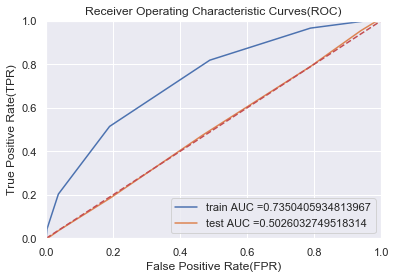

In [167]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

KNN = KNeighborsClassifier(n_neighbors=41,algorithm='brute',n_jobs=-1)
KNN.fit(X_train_tfidf_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, KNN.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, KNN.predict_proba(X_test_tfidf_std)[:,1])
sns.set(font_scale=1)#for label size
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using seaborn

In [168]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.4189021711813577 for threshold 0.902

Train confusion matrix:

[[ 5258    11]
 [ 3002 21213]]

Test confusion matrix:

[[ 563  604]
 [1729 6319]]


In [169]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

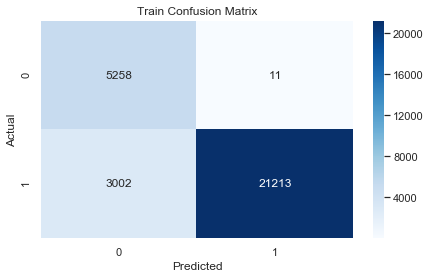

In [170]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

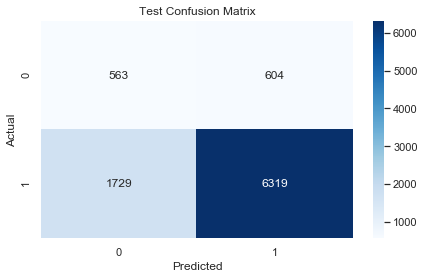

In [171]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

###  Applying KNN brute force on AVG W2V

In [172]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [173]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [174]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [175]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10283
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'hi', 'disappointed', 'past', 'shipment', 'received', 'one', 'coconut', 'water', 'boxes', 'leaking', 'spoiled', 'thanks', 'called', 'bob', 'red', 'mill', 'customer', 'service', 'g', 'search', 'company', 'number', 'contact', 'us', 'site', 'annoyed', 'learn', 'none', 'baking', 'soda', 'contains']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [176]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [177]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 29484/29484 [01:01<00:00, 477.69it/s]


In [178]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(29484, 50)
[ 0.52023679 -0.4291717  -0.5455968  -0.700416   -0.05688469  0.07938598
 -0.42001675  0.6956412   0.21053369  0.21434391  0.1589691  -0.67774694
 -0.37792088 -0.14468678 -0.6275123  -0.43287395 -0.29026866  0.31416081
  1.06157022  0.26584916 -0.26615134 -0.02503068 -0.04422839 -0.4052236
  0.20787971  0.65897692 -0.31419454 -0.06651717  0.17603417 -0.99397002
 -0.84190223 -0.07324278  0.26842265  0.1232782  -0.61810422  0.34172621
 -0.11794027  0.16212478 -0.36688257 -0.51505553 -0.18685574  0.22457757
  0.35717844  0.2517235  -0.20669546 -0.7103412   0.43834267 -0.33943781
 -0.16237451 -0.99218096]


## Converting CV data text

In [179]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [180]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|█████████████████████████████████████████████████████████████████████████████| 7372/7372 [00:16<00:00, 457.09it/s]


In [181]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(7372, 50)
[ 0.43069782 -0.37008645 -0.10939502 -1.24335464  0.92244627  0.00639142
  0.13645076  0.26256892  0.42208494 -0.16989093 -0.19323663 -0.66579605
 -0.35897713  0.50981732 -0.40793726 -0.62858534 -0.23618183 -0.04889977
 -0.09115106  0.21916951 -0.08332395  0.12353178 -0.25300997 -0.62813363
 -0.08327015  0.36582203  0.14620235  0.7848041   0.2842487   0.18367344
 -0.31770808 -0.47721518  0.18450309  0.09732382 -0.54330005 -0.44501564
 -0.26129532  0.02975952 -0.18385577  0.00407206 -0.72433808  0.09366041
  0.34275782  0.20431167 -0.27272613 -0.24146806  0.3768382  -0.25543862
  0.60576348 -0.56941999]


## Converting Test data text

In [182]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [183]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 9215/9215 [00:20<00:00, 439.50it/s]


(9215, 50)
[ 0.54527139  0.71310512 -0.76230634 -0.72926932 -0.92783795 -0.68942193
  1.29104396  0.10624126 -0.0234609  -0.04982502 -0.3112514  -0.28980261
  0.77151814  0.24885453 -0.88082737 -0.66158236 -0.32941375 -0.84236021
  0.35250858  0.76266582 -0.23633608  0.18796908 -0.35043431  0.70955819
 -1.93830759  0.99709964 -1.08597829 -0.35446889 -0.4422547  -1.02945663
  0.55697203  0.93437961  0.28350352 -0.37478586 -0.24245669  0.91354714
 -0.02837357 -1.09045607  0.28428088 -0.19825365  1.42309426 -0.57255735
 -0.7871113  -0.11588924 -0.36124148  0.54666242 -0.02812555 -1.54347187
 -0.44480924 -0.01933532]


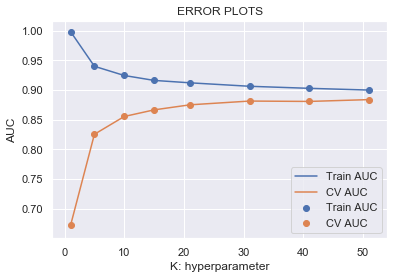

In [184]:
# finding best k value
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
sns.set(font_scale=1)#for label size
plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above graph,we can see that the best k value is 51 for which the CV AUC is high and the gap is
very less.

In [101]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_avgw2v_std=sc.fit_transform(sent_vectors_train)
X_cv_avgv2v_std=sc.transform(sent_vectors_cv)
X_test_avgw2v_std=sc.transform(sent_vectors_test)

## Building KNN on Avg w2v for best k value:51

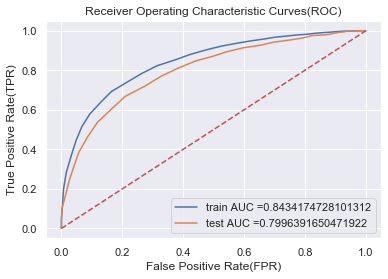

In [102]:
neigh = KNeighborsClassifier(n_neighbors=51,algorithm='brute')
neigh.fit(X_train_avgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train1_fpr, train1_tpr, thresholds_tr_avgw2v = roc_curve(y_train, neigh.predict_proba(X_train_avgw2v_std)[:,1])
test1_fpr, test1_tpr, thresholds_te_avgw2v = roc_curve(y_test, neigh.predict_proba(X_test_avgw2v_std)[:,1])
sns.set(font_scale=1)#for label size
plt.plot(train1_fpr, train1_tpr, label="train AUC ="+str(auc(train1_fpr, train1_tpr)))
plt.plot(test1_fpr, test1_tpr, label="test AUC ="+str(auc(test1_fpr, test1_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting Confusion Matric using Seaborn

In [103]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_avgw2v, train1_fpr, train1_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5803450146668803 for threshold 0.804

Train confusion matrix:

[[1476  553]
 [2596 7761]]

Test confusion matrix:

[[ 365  200]
 [ 883 2423]]


In [104]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

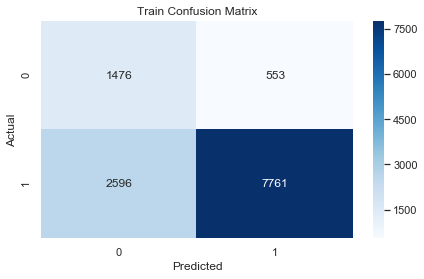

In [105]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

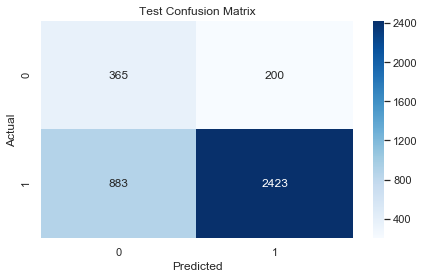

In [106]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying KNN brute force on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [191]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [192]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 29484/29484 [11:42<00:00, 38.30it/s]


In [193]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [194]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(29484, 50)
[ 0.56861379 -0.52337956 -0.478346   -0.71824076  0.00547185  0.07498104
 -0.34939816  0.55379485  0.09779096  0.14811773  0.17550163 -0.58222919
 -0.32764328 -0.09503195 -0.57971918 -0.29703056 -0.26034667  0.22276638
  0.92546515  0.05078415 -0.31231661 -0.0846748  -0.03237524 -0.29626726
  0.21471704  0.64436478 -0.33396871 -0.16606834  0.1735424  -0.87518075
 -0.77682654  0.04963493  0.26624491  0.11420461 -0.54234917  0.36248274
 -0.11975898  0.15764574 -0.39127286 -0.3875479  -0.02527276  0.12876745
  0.3019428   0.07478102 -0.19562282 -0.62141951  0.40910213 -0.30077051
 -0.15720774 -0.9713199 ]


## Converting CV data to tfidf-w2v

In [195]:
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [196]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_cv.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 7372/7372 [01:15<00:00, 98.12it/s]


In [197]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [198]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(7372, 50)
[ 0.59119428 -0.42577376 -0.08120546 -1.17621783  1.25984401  0.16553444
  0.00325742  0.24347869  0.48031437 -0.20934081 -0.1772565  -0.7013452
 -0.41081086  0.59022102 -0.36817745 -0.72927417 -0.324785   -0.01386837
 -0.0465617   0.11010186 -0.02922013  0.07913642 -0.24870213 -0.7851787
 -0.02603877  0.54809382  0.2439086   0.94402995  0.29312454  0.44050537
 -0.2997451  -0.44657235  0.01666321  0.02811419 -0.62506045 -0.41191934
 -0.42938103  0.14247246 -0.25331545  0.25361408 -0.88934609  0.37690417
  0.39598174  0.22427849 -0.24618211 -0.11705292  0.23919015 -0.28817426
  0.74931601 -0.56402525]


## Converting Test data to tfidf-w2v

In [199]:
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [200]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_test.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 9215/9215 [01:43<00:00, 88.95it/s]


In [201]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [202]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(9215, 50)
[ 5.80421684e-01  6.25275703e-01 -7.78674913e-01 -7.56883254e-01
 -8.71545901e-01 -7.18072695e-01  1.29917839e+00  1.08809201e-01
  1.20724349e-02 -5.43773455e-02 -4.10454837e-01 -3.07090754e-01
  9.69523241e-01  3.38447483e-01 -7.61281009e-01 -6.90311132e-01
 -3.62525274e-01 -8.63034320e-01  2.80586681e-01  8.27267557e-01
 -1.47359390e-01  1.43094865e-01 -3.35606302e-01  6.55500889e-01
 -1.91556196e+00  8.69213261e-01 -9.34252503e-01 -2.80222381e-01
 -4.98533948e-01 -9.60230864e-01  5.57207097e-01  9.06724201e-01
  2.61556820e-01 -4.49611086e-01 -3.48164722e-01  8.89404064e-01
 -8.55865593e-02 -1.10991800e+00  2.75429987e-01 -7.89623727e-02
  1.47012977e+00 -5.32729738e-01 -8.11583459e-01 -7.34137805e-02
 -2.65093797e-01  5.84046786e-01 -1.11486467e-01 -1.69284550e+00
 -4.47856152e-01  1.62010003e-03]


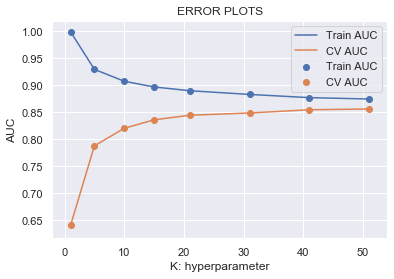

In [203]:
# finding best k value
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred =  neigh.predict_proba(tfidf_sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above graph,we can see that the best k value is at 51 where the gap is less and CV AUC is high

In [204]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

## Building KNN on tfidf-w2v for best k value :51

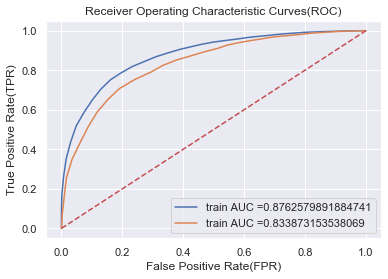

In [205]:
neigh = KNeighborsClassifier(n_neighbors=51,algorithm='brute')
neigh.fit(X_train_tfidfavgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf_w2v = roc_curve(y_train, neigh.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf_w2v = roc_curve(y_test, neigh.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using Seaborn

In [207]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf_w2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6325832507209586 for threshold 0.804

Train confusion matrix:

[[ 4203  1066]
 [ 5097 19118]]

Test confusion matrix:

[[ 821  346]
 [1681 6367]]


In [208]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

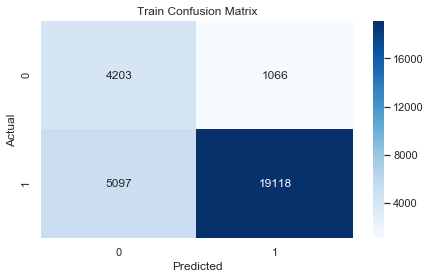

In [209]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

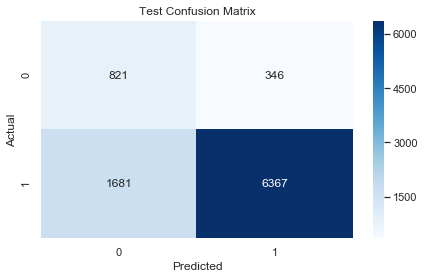

In [210]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Applying KNN kd-tree

###  Applying KNN kd-tree on BOW

In [2]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
8696,9527,B00005V3DC,A8KY7S48EW7LW,"A. Daly ""AD""",0,0,1,1350172800,The Best Cleansing Tea I've Ever Had,I've used this brand for years. If you're feel...


## Preprocessing

## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:10<00:00, 1818.98it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...


In [15]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [17]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...


## Sorting data in descending order based on time column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
15069,16426,B007TJGZ54,A29BJSTYH9W3JI,Harry,0,0,1,1351209600,super coffee,Great coffee and so easy to brew. This coffee...,great coffee easy brew coffee great aroma good...
7620,8322,B003VXFK44,A3GFZIL1E0Z5V8,bloomen1,0,0,1,1351209600,Rodeo Drive is Crazy Good Coffee!,Rodeo Drive is my absolute favorite and I'm re...,rodeo drive absolute favorite ready order find...
6548,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...,ordered raisins multiple times always great ar...
7156,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...,not like sour taste sour kind taste not like s...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...
8731,9564,B001EQ5IPQ,AA2104NO2VE8H,Lakshminarayan Iyer,0,0,0,1351209600,Extremely dissapointed,"Hi,<br />I am very disappointed with the past ...",hi disappointed past shipment received one coc...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
19181,20930,B001L1MKLY,A38XYFHXEUNUW6,bleaufire,0,0,1,1351209600,Yummy & Subtle,Just made my first pot of this wonderful coffe...,made first pot wonderful coffee simply delish ...


In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [19]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
15069,great coffee easy brew coffee great aroma good...,1
7620,rodeo drive absolute favorite ready order find...,1
6548,ordered raisins multiple times always great ar...,1
7156,not like sour taste sour kind taste not like s...,0


In [20]:
final_df.shape

(19354, 2)

In [21]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [22]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=3,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) # this is random splitting

In [23]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(12386,) (12386,)
(3097,) (3097,)
(3871,) (3871,)


In [24]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(12386, 500) (12386,)
(3097, 500) (3097,)
(3871, 500) (3871,)


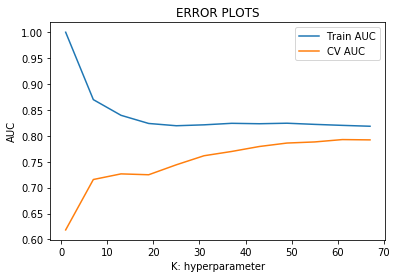

In [39]:
# Hyper parameter tuning to find best k
# Simple Cross validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = list(range(1,70,6))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  neigh.predict_proba(X_test_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above graph,we can see that the best k value is between 60 to 70 where the gap between CV AUC and Train AUC
is less abd CV AUC is maximum.

## Scaling the vectorized data before applying KNN

In [40]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

In [41]:
type(X_train_bow_std)

scipy.sparse.csr.csr_matrix

## Converting Sparse Matrix to dense since kd tree accept only dense matrices

In [42]:
X_train_bow_std=X_train_bow_std.toarray()
X_cv_bow_std=X_cv_bow_std.toarray()
X_test_bow_std=X_test_bow_std.toarray()


In [43]:
type(X_train_bow_std)

numpy.ndarray

## Building KNN model with best k value:69 on "kd tree" and BOW

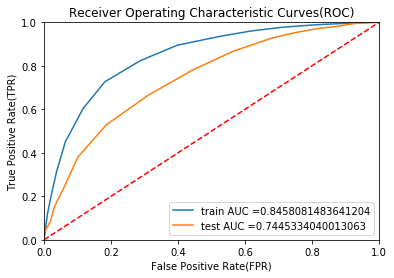

In [44]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

KNN = KNeighborsClassifier(n_neighbors=69,algorithm='kd_tree',n_jobs=-1)
KNN.fit(X_train_bow_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, KNN.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, KNN.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using Seaborn

In [45]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_bow, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5947851451814863 for threshold 0.841

Train confusion matrix:

[[1774  255]
 [3982 6375]]

Test confusion matrix:

[[ 452  113]
 [1484 1822]]


In [46]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

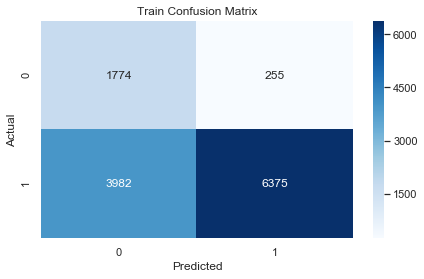

In [47]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

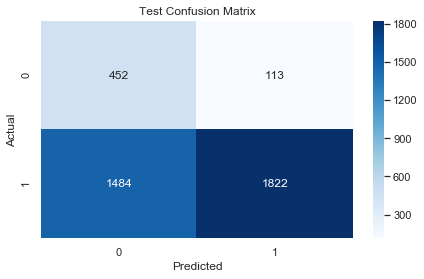

In [48]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying KNN kd-tree on TFIDF

In [49]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500,norm='l2')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(12386, 500) (12386,)
(3097, 500) (3097,)
(3871, 500) (3871,)


In [50]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

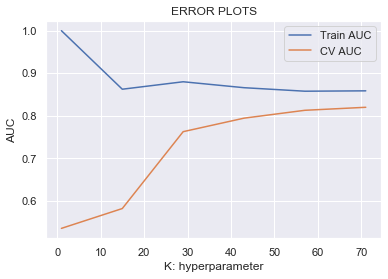

In [51]:
# Hyper parameter tuning to find best k
# Simple Cross validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = list(range(1,72,14))
for i in K:
    neigh1 = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh1.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh1.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh1.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred =  neigh1.predict_proba(X_test_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above graph,we can see that the best k value is 71

## Converting Sparse Matrix to dense since kd tree accept only dense matrices

In [52]:
X_train_tfidf = X_train_tfidf.toarray()
X_cv_tfidf = X_cv_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [53]:
type(X_train_tfidf)

numpy.ndarray

In [54]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building KNN on TF-IDF with best k value :71

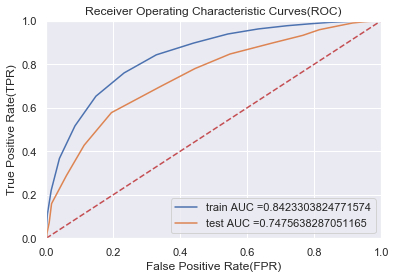

In [55]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

KNN = KNeighborsClassifier(n_neighbors=71,algorithm='kd_tree',n_jobs=-1)
KNN.fit(X_train_tfidf_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, KNN.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, KNN.predict_proba(X_test_tfidf_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using Seaborn

In [56]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5835503001210648 for threshold 0.859

Train confusion matrix:

[[1659  370]
 [2800 7557]]

Test confusion matrix:

[[ 423  142]
 [1188 2118]]


In [57]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

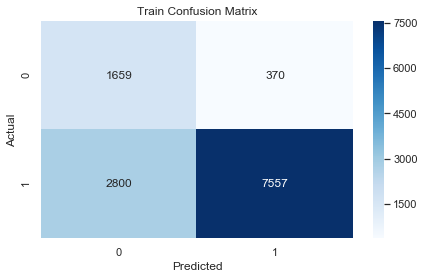

In [58]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

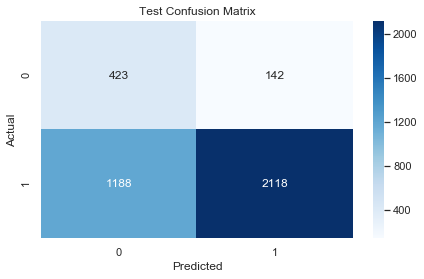

In [59]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying KNN kd-tree on AVG W2V

In [60]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [61]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [62]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [63]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6570
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'great', 'coffee', 'brew', 'aroma', 'good', 'last', 'drop', 'actually', 'like', 'brands', 'way', 'taste', 'rodeo', 'drive', 'absolute', 'favorite', 'order', 'find', 'not', 'know', 'discontinuing', 'arrived', 'fast', 'ordered', 'raisins', 'multiple', 'times', 'always', 'arrive', 'timely', 'go']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [64]:
from tqdm import tqdm
import numpy as np

In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 12386/12386 [00:19<00:00, 640.07it/s]


In [66]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])
print(type(sent_vectors_train))

(12386, 50)
[-0.27921656  0.55093544 -0.18683871 -0.15465515 -0.05918134 -0.08600012
 -0.6293034  -0.61372146  0.4006317  -0.11224824 -0.36085678  0.20263904
 -0.50386607 -0.12714105  0.18179243 -0.03319425 -0.20103728 -0.31048331
  0.47588931  0.13036859 -0.29060037  0.1002397   0.18664993  0.14533512
  0.4139313  -0.43676546 -0.2552244   0.32475525 -0.60359993  0.1738166
  0.71387012 -0.47155025 -0.54971957  0.33471454 -0.12403917  0.41929137
 -0.1262373  -0.14264411  0.09529988 -0.54552712 -0.53677894 -0.046294
 -0.00176676 -0.45910682 -0.95058834  0.33636375 -0.36570078  0.20606369
  0.06281778  0.03517571]
<class 'numpy.ndarray'>


## Converting CV data text

In [67]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|█████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:04<00:00, 646.85it/s]


In [69]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(3097, 50)
[-0.40806772  0.35513514 -0.25321195  0.08576465 -0.24159437  0.20975619
 -0.93739081 -0.3135946   0.43166031  0.07501557 -0.10302853  0.07426269
 -0.04689391 -0.26599877  0.48727527 -0.37146672  0.02359218 -0.49926575
  0.25099078  0.29571962 -0.07488982  0.10295976  0.17301628  0.23616541
  0.44927558 -0.24192582 -0.03622368  0.11993604 -0.5660301   0.19187153
  0.6731401  -0.28897605 -0.82017221  0.86718751 -0.23246698  0.651969
  0.12108521 -0.18461444 -0.11436824 -0.79300746 -0.5506689   0.09472212
 -0.05355763 -0.7355061  -0.73224173  0.7419105  -0.05224484  0.0256342
  0.07166979  0.19441991]


## Converting Test data text

In [70]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [71]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:07<00:00, 546.48it/s]


(3871, 50)
[-0.54221278  0.47962695 -0.25970445 -0.01645626 -0.10438567 -0.10158603
 -0.75247087 -0.38882665  0.4213666  -0.21144666 -0.3091342   0.15371759
 -0.26936612 -0.15517761  0.03092808 -0.31756202 -0.18819277 -0.38292943
  0.36029681  0.24190654 -0.15555089  0.27895181  0.05595003  0.36084862
  0.20047973 -0.21109957  0.06089735  0.14796971 -0.44952906  0.10280644
  0.63981872 -0.38848099 -0.56139359  0.38462516 -0.21275246  0.50164683
 -0.08606056  0.03394551 -0.09715352 -0.56846932 -0.40405082 -0.03191856
 -0.15332286 -0.626485   -0.52048981  0.59845867 -0.12584514  0.12411084
  0.01164129  0.20277062]


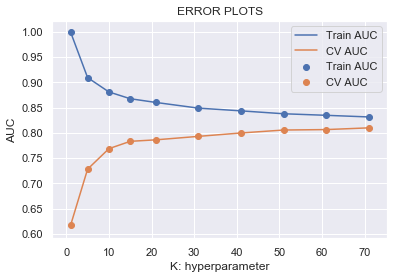

In [73]:
# finding best k value
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51,61,71]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best k value is 71 where CV AUC is maximum and the gap between Train AUC and
CV AUC is less.

In [75]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_avgw2v_std=sc.fit_transform(sent_vectors_train)
X_cv_avgv2v_std=sc.transform(sent_vectors_cv)
X_test_avgw2v_std=sc.transform(sent_vectors_test)

## Building KNN on Avg w2v for best k value:71

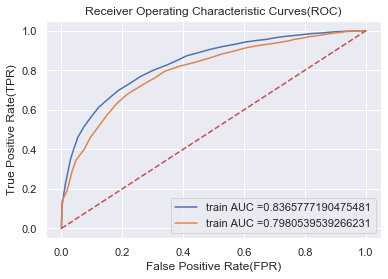

In [76]:
neigh = KNeighborsClassifier(n_neighbors=71,algorithm='kd_tree',n_jobs=-1)
neigh.fit(X_train_avgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_avgw2v = roc_curve(y_train, neigh.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_avgw2v = roc_curve(y_test, neigh.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using Seaborn

In [77]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5689825425507985 for threshold 0.789

Train confusion matrix:

[[1477  552]
 [2378 7979]]

Test confusion matrix:

[[ 385  180]
 [ 765 2541]]


In [78]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

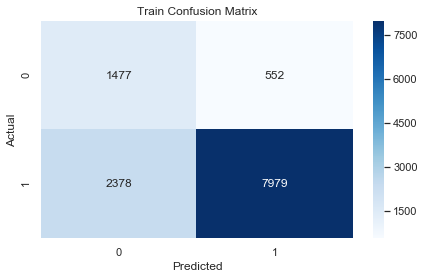

In [79]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

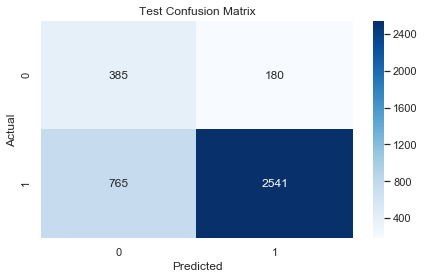

In [80]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying KNN kd-tree on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [81]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12386/12386 [02:27<00:00, 84.06it/s]


In [83]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [84]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(12386, 50)
[-0.30184412  0.50856574 -0.19956938 -0.10085527 -0.03268397 -0.12695282
 -0.51508562 -0.59764733  0.34379438 -0.11819333 -0.35660386  0.14734365
 -0.49477019 -0.14991488  0.12946549 -0.06494332 -0.20957659 -0.2235037
  0.44375636  0.09989589 -0.28973419  0.11424928  0.15964099  0.17937505
  0.32324192 -0.34883504 -0.17143327  0.25568239 -0.54538255  0.16167315
  0.67072343 -0.43227988 -0.42007762  0.27611192 -0.09181914  0.36851536
 -0.08780424 -0.10411007  0.06656688 -0.47656905 -0.46673344 -0.03144542
 -0.04405689 -0.41581189 -0.80324274  0.29077535 -0.33194393  0.19473522
  0.04214557  0.05569914]


## Converting CV data to tfidf-w2v

In [85]:
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [86]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_cv.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:20<00:00, 152.15it/s]


In [87]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [88]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(3097, 50)
[-0.34614539  0.33576406 -0.17235605  0.05097452 -0.20849446  0.17149755
 -0.9094883  -0.31999056  0.38534498  0.04292965 -0.10803922  0.14446519
 -0.03393416 -0.20833964  0.44498483 -0.36335985  0.04547232 -0.50773676
  0.24016275  0.25586347 -0.08993771  0.10980504  0.14299729  0.204253
  0.52524993 -0.31449231 -0.09430394  0.16608472 -0.56548058  0.18235937
  0.66221396 -0.2520604  -0.75305757  0.76356073 -0.26235087  0.63305963
  0.11079744 -0.18339855 -0.07635833 -0.73256705 -0.5640768   0.05823856
 -0.02639258 -0.64474595 -0.7352282   0.66956417 -0.06244071  0.02946241
  0.04614211  0.05725495]


## Converting Test data to tfidf-w2v

In [89]:
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_test.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:31<00:00, 122.37it/s]


In [91]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [92]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(3871, 50)
[-0.51650661  0.44812165 -0.24150638  0.00186287 -0.0348437  -0.15202019
 -0.62858175 -0.37253965  0.38103341 -0.20225487 -0.29225244  0.12013325
 -0.27578749 -0.16085787  0.02153493 -0.28662535 -0.20826079 -0.27753748
  0.351066    0.21238935 -0.18922624  0.23682471  0.08343937  0.32263335
  0.14542587 -0.19523124  0.10477358  0.1589911  -0.40928897  0.1102983
  0.59044117 -0.39782242 -0.47844031  0.30918787 -0.23225425  0.42586254
 -0.06343576  0.02879416 -0.03721847 -0.52269004 -0.34904804 -0.02830986
 -0.1614517  -0.52367095 -0.4916683   0.50382273 -0.12133076  0.12590623
 -0.01949203  0.20132144]


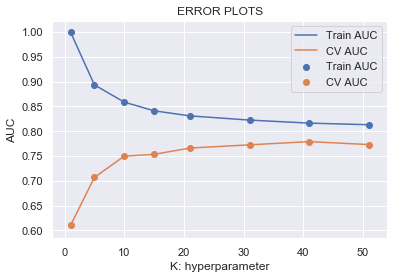

In [93]:
# finding best k value
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred =  neigh.predict_proba(tfidf_sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best k value is 51 where CV AUC is maximum and the gap between Train AUC
and CV AUC is less.

In [94]:
# Standardizing the data before applying KNN

sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

## Building KNN on tfidf-w2v for best k value :51

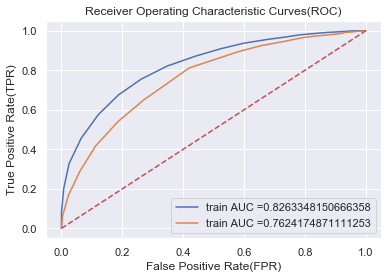

In [96]:
neigh = KNeighborsClassifier(n_neighbors=31,algorithm='kd_tree')
neigh.fit(X_train_tfidfavgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf_avgw2v = roc_curve(y_train, neigh.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf_avgw2v = roc_curve(y_test, neigh.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion Matrix using seaborn

In [97]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5573030966025935 for threshold 0.806

Train confusion matrix:

[[1569  460]
 [3172 7185]]

Test confusion matrix:

[[ 399  166]
 [1078 2228]]


In [98]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

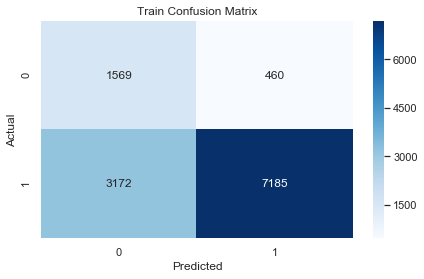

In [99]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

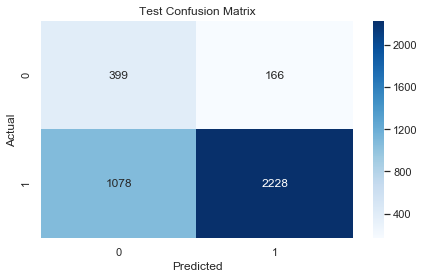

In [100]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

# [6] Conclusions

# Check http://zetcode.com/python/prettytable/ to print pretty table

In [133]:
from prettytable import PrettyTable

In [134]:
x=PrettyTable()

In [137]:
x.field_names=['Vectorizer','Model','Hyper Parameter_k','AUC']

In [138]:
x.add_row(['BOW','Brute',55,0.62])
x.add_row(['TFIDF','Brute',43,0.54])
x.add_row(['AVGW2V','Brute',51,0.87])
x.add_row(['TFIDF_AVGW2V','Brute',51,0.85])

x.add_row(['BOW','kd_tree',69,0.76])
x.add_row(['TFIDF','kd_tree',71,0.75])
x.add_row(['AVGW2V','kd_tree',21,0.80])
x.add_row(['TFIDF_AVGW2V','kd_tree',31,0.76])

In [139]:
print(x)

+--------------+---------+-------------------+------+
|  Vectorizer  |  Model  | Hyper Parameter_k | AUC  |
+--------------+---------+-------------------+------+
|     BOW      |  Brute  |         55        | 0.62 |
|    TFIDF     |  Brute  |         43        | 0.54 |
|    AVGW2V    |  Brute  |         51        | 0.87 |
| TFIDF_AVGW2V |  Brute  |         51        | 0.85 |
|     BOW      | kd_tree |         69        | 0.76 |
|    TFIDF     | kd_tree |         71        | 0.75 |
|    AVGW2V    | kd_tree |         21        | 0.8  |
| TFIDF_AVGW2V | kd_tree |         31        | 0.76 |
+--------------+---------+-------------------+------+
